# Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

# Kasthuri Naresh kumar
# Id: 9042735

# Obtain the Data: Get the Dogs vs Cats dataset

In [14]:
import os
import shutil
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import tensorflow as tf

In [ ]:


# Define paths
source_dir = pathlib.Path(r"C:\Users\Kasthuri Vandana\OneDrive\Desktop\canada\Foundation_ml\cat\train")  # Source folder with mixed images
target_base_dir = pathlib.Path(r"C:\Users\Kasthuri Vandana\OneDrive\Desktop\canada\Foundation_ml\cat\target")  # Target folder for organized data

# Define limits (total 5000 images: 2500 cats + 2500 dogs)
train_limit = 1000  # 1000 cats + 1000 dogs = 2000
val_limit = 500     # 500 cats + 500 dogs = 1000
test_limit = 1000   # 1000 cats + 1000 dogs = 2000

# Function to segregate and create subsets
def segregate_and_subset_images():
    subsets = {
        "train": (0, train_limit),
        "validation": (train_limit, train_limit + val_limit),
        "test": (train_limit + val_limit, train_limit + val_limit + test_limit)
    }
    
    cat_counts = {"train": 0, "validation": 0, "test": 0}
    dog_counts = {"train": 0, "validation": 0, "test": 0}
    
    # Create directories for train, validation, and test with cats and dogs subfolders
    for subset in subsets:
        for category in ("cats", "dogs"):
            dir_path = target_base_dir / subset / category
            os.makedirs(dir_path, exist_ok=True)
    
    # Get all files from source directory
    all_files = os.listdir(source_dir)
    
    # Process files
    for filename in all_files:
        source_path = source_dir / filename
        
        # Check if it's a valid image file
        if os.path.isfile(source_path) and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            fname_lower = filename.lower()
            
            # Segregate cats
            if 'cat' in fname_lower:
                for subset, (start, end) in subsets.items():
                    if cat_counts[subset] < (end - start):
                        target_path = target_base_dir / subset / "cats" / filename
                        shutil.copyfile(source_path, target_path)
                        cat_counts[subset] += 1
                        break
            
            # Segregate dogs
            elif 'dog' in fname_lower:
                for subset, (start, end) in subsets.items():
                    if dog_counts[subset] < (end - start):
                        target_path = target_base_dir / subset / "dogs" / filename
                        shutil.copyfile(source_path, target_path)
                        dog_counts[subset] += 1
                        break
    
    # Print summary
    print("\nSegregation and subset creation complete!")
    for subset in subsets:
        print(f"{subset.capitalize()}: {cat_counts[subset]} cats, {dog_counts[subset]} dogs")
    print(f"Total images processed: {sum(cat_counts.values()) + sum(dog_counts.values())}")

# Run the segregation and subsetting
if __name__ == "__main__":
    segregate_and_subset_images()


Segregation and subset creation complete!
Train: 1000 cats, 1000 dogs
Validation: 500 cats, 500 dogs
Test: 1000 cats, 1000 dogs
Total images processed: 5000


# EDA: Explore the data with relevant graphs, statistics and insights

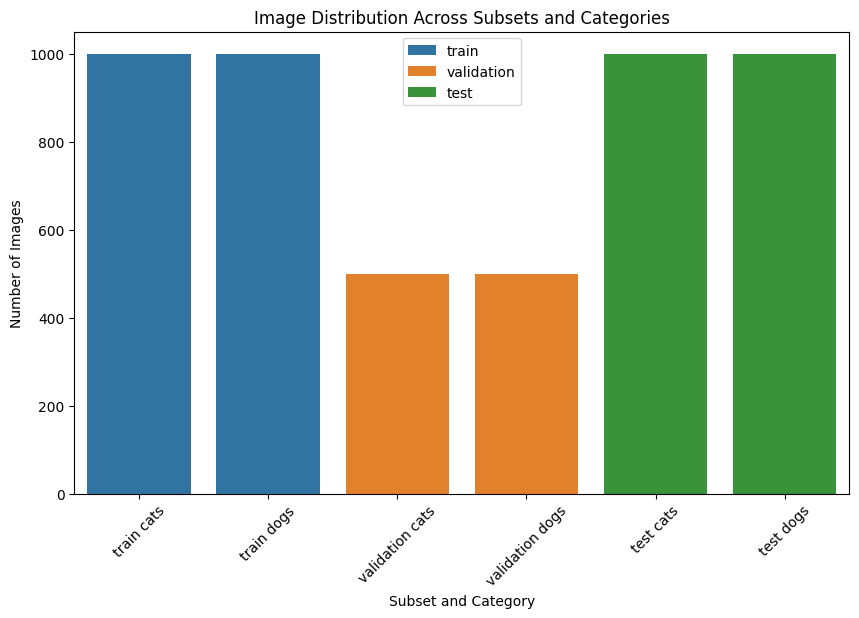

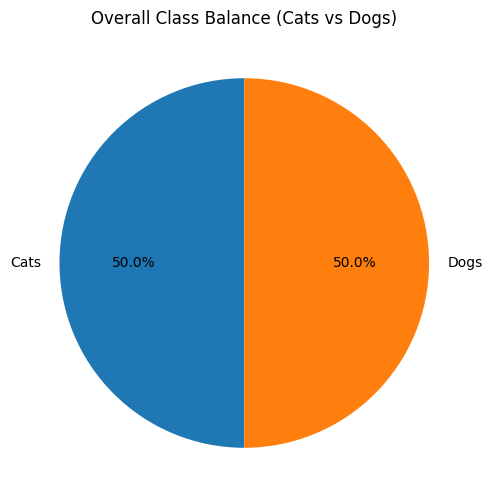

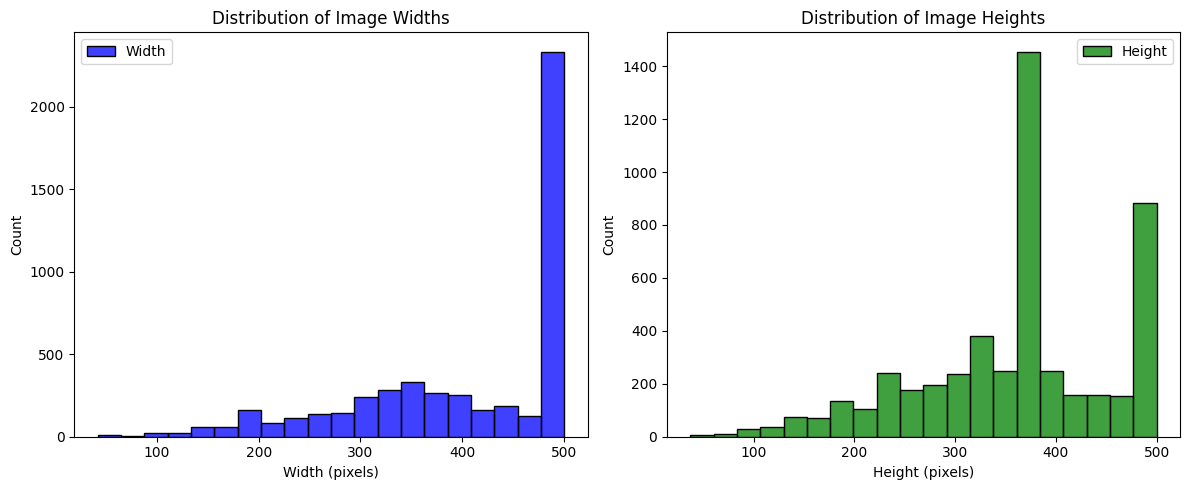

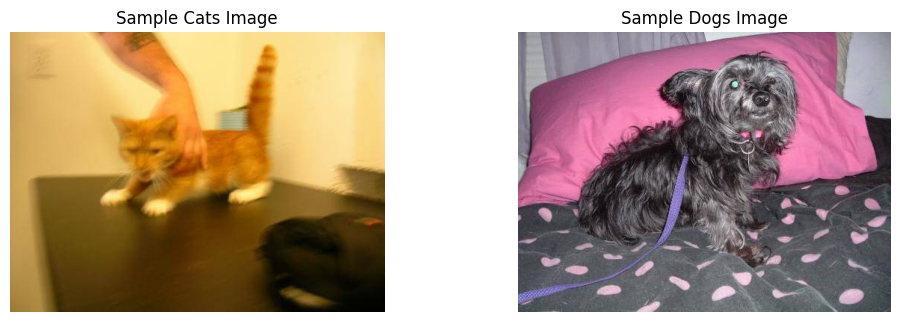

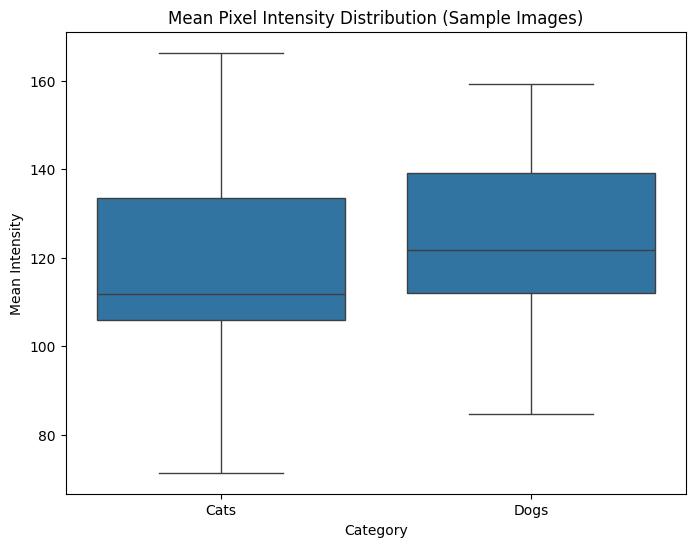

EDA Insights:
Total Images: 5000
Class Balance: Cats = 2500 (50.0%), Dogs = 2500 (50.0%)
Image Size Stats: Avg Width = 406.3, Avg Height = 361.3
Pixel Intensity (Cats): Mean = 117.8, Std = 58.5
Pixel Intensity (Dogs): Mean = 123.4, Std = 51.8

Observations:
- Class distribution appears balanced across subsets.
- Image sizes vary, which may require resizing for model input.
- Pixel intensity differences might indicate visual distinctions between cats and dogs.


In [ ]:
from PIL import Image
import pandas as pd

# Define paths (assuming data is already organized from previous step)
target_base_dir = pathlib.Path(r"C:\Users\Kasthuri Vandana\OneDrive\Desktop\canada\Foundation_ml\cat\target")

# EDA Function
def perform_extended_eda():
    subsets = ["train", "validation", "test"]
    categories = ["cats", "dogs"]
    
    # 1. Image Counts per Subset and Category
    counts = {subset: {cat: len(os.listdir(target_base_dir / subset / cat)) for cat in categories} for subset in subsets}
    
    # Bar Plot for Image Distribution
    plt.figure(figsize=(10, 6))
    x_labels = [f"{subset} {cat}" for subset in subsets for cat in categories]
    heights = [counts[subset][cat] for subset in subsets for cat in categories]
    sns.barplot(x=x_labels, y=heights, hue=[subset for subset in subsets for _ in categories])
    plt.title("Image Distribution Across Subsets and Categories")
    plt.xlabel("Subset and Category")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()
    
    # 2. Class Balance Check
    total_cats = sum(counts[subset]["cats"] for subset in subsets)
    total_dogs = sum(counts[subset]["dogs"] for subset in subsets)
    plt.figure(figsize=(6, 6))
    plt.pie([total_cats, total_dogs], labels=["Cats", "Dogs"], autopct='%1.1f%%', startangle=90)
    plt.title("Overall Class Balance (Cats vs Dogs)")
    plt.show()
    
    # 3. Image Size Distribution
    sizes = []
    for subset in subsets:
        for cat in categories:
            for fname in os.listdir(target_base_dir / subset / cat):
                img_path = target_base_dir / subset / cat / fname
                with Image.open(img_path) as img:
                    sizes.append(img.size)  # (width, height)
    
    widths, heights = zip(*sizes)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, bins=20, color='blue', label='Width')
    plt.title("Distribution of Image Widths")
    plt.xlabel("Width (pixels)")
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.histplot(heights, bins=20, color='green', label='Height')
    plt.title("Distribution of Image Heights")
    plt.xlabel("Height (pixels)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. Sample Images
    plt.figure(figsize=(12, 8))
    for i, cat in enumerate(categories):
        sample_img_path = target_base_dir / "train" / cat / os.listdir(target_base_dir / "train" / cat)[0]
        img = Image.open(sample_img_path)
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f"Sample {cat.capitalize()} Image")
        plt.axis("off")
    plt.show()
    
    # 5. Pixel Intensity Statistics (for a few sample images)
    pixel_stats = {"cats": [], "dogs": []}
    for cat in categories:
        for i in range(min(5, counts["train"][cat])):  # Analyze 5 images per category
            img_path = target_base_dir / "train" / cat / os.listdir(target_base_dir / "train" / cat)[i]
            img = np.array(Image.open(img_path).convert('L'))  # Convert to grayscale
            pixel_stats[cat].append({"mean": np.mean(img), "std": np.std(img)})
    
    # Boxplot of Pixel Intensities
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=pd.DataFrame({
        "Category": ["Cats"] * 5 + ["Dogs"] * 5,
        "Mean Intensity": [stat["mean"] for stat in pixel_stats["cats"]] + [stat["mean"] for stat in pixel_stats["dogs"]]
    }), x="Category", y="Mean Intensity")
    plt.title("Mean Pixel Intensity Distribution (Sample Images)")
    plt.show()
    
    # 6. Insights
    print("EDA Insights:")
    print(f"Total Images: {total_cats + total_dogs}")
    print(f"Class Balance: Cats = {total_cats} ({total_cats/(total_cats+total_dogs)*100:.1f}%), Dogs = {total_dogs} ({total_dogs/(total_cats+total_dogs)*100:.1f}%)")
    print(f"Image Size Stats: Avg Width = {np.mean(widths):.1f}, Avg Height = {np.mean(heights):.1f}")
    print(f"Pixel Intensity (Cats): Mean = {np.mean([s['mean'] for s in pixel_stats['cats']]):.1f}, Std = {np.mean([s['std'] for s in pixel_stats['cats']]):.1f}")
    print(f"Pixel Intensity (Dogs): Mean = {np.mean([s['mean'] for s in pixel_stats['dogs']]):.1f}, Std = {np.mean([s['std'] for s in pixel_stats['dogs']]):.1f}")
    print("\nObservations:")
    print("- Class distribution appears balanced across subsets.")
    print("- Image sizes vary, which may require resizing for model input.")
    print("- Pixel intensity differences might indicate visual distinctions between cats and dogs.")

# Run EDA
perform_extended_eda()

# Train two networks

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(target_base_dir / "train", target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(target_base_dir / "validation", target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(target_base_dir / "test", target_size=(150, 150), batch_size=32, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# 3.1 Define a Neural Network of your choice

In [18]:
def build_custom_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

custom_model = build_custom_model()

# Callbacks
checkpoint_custom = keras.callbacks.ModelCheckpoint("custom_model_best.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Train Custom Model
history_custom = custom_model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_custom])

c:\Users\Kasthuri Vandana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Kasthuri Vandana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4997 - loss: 0.9045

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 463ms/step - accuracy: 0.4998 - loss: 0.9022 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5208 - loss: 0.6989

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step - accuracy: 0.5211 - loss: 0.6989 - val_accuracy: 0.6200 - val_loss: 0.6740
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.6249 - loss: 0.6627 - val_accuracy: 0.5930 - val_loss: 0.6685
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6723 - loss: 0.5938

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.6725 - loss: 0.5936 - val_accuracy: 0.6670 - val_loss: 0.6074
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7594 - loss: 0.5108

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 400ms/step - accuracy: 0.7593 - loss: 0.5108 - val_accuracy: 0.6970 - val_loss: 0.5994
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - accuracy: 0.8006 - loss: 0.4330 - val_accuracy: 0.6550 - val_loss: 0.6661
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.8467 - loss: 0.3615 - val_accuracy: 0.6830 - val_loss: 0.6943
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.8909 - loss: 0.2464 - val_accuracy: 0.6890 - val_loss: 0.7477
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 399ms/step - accuracy: 0.9178 - loss: 0.2247 - val_accuracy: 0.6730 - val_loss: 0.9166
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.9306 - loss: 0.1572 - val_accuracy: 0.6700 - val_loss: 1.2786
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.9605 - loss: 0.0949 - val_accuracy: 0.6770 - val_loss: 1.4888
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.9840 - loss: 0.0498 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 399ms/step - accuracy: 0.9965 - loss: 0.0149 - val_accuracy: 0.7010 - val_loss: 1.8250
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9994 - loss: 0.0052

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 416ms/step - accuracy: 0.9994 - loss: 0.0052 - val_accuracy: 0.7080 - val_loss: 2.0135
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.9949 - loss: 0.0149 - val_accuracy: 0.6900 - val_loss: 1.8005
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - accuracy: 0.9763 - loss: 0.0773 - val_accuracy: 0.6920 - val_loss: 1.3568
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 424ms/step - accuracy: 0.9801 - loss: 0.0607 - val_accuracy: 0.7030 - val_loss: 1.6401
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.9958 - loss: 0.0125 - val_accuracy: 0.6940 - val_loss: 1.8741


# 3.2 Fine-Tune VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7167 - loss: 0.7004

63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.7181 - loss: 0.6964 - val_accuracy: 0.8710 - val_loss: 0.3120
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9043 - loss: 0.2381

63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9045 - loss: 0.2378 - val_accuracy: 0.8760 - val_loss: 0.2725
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9589 - loss: 0.1279

63/63 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9588 - loss: 0.1281 - val_accuracy: 0.8870 - val_loss: 0.2652
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9764 - loss: 0.0872

63/63 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9763 - loss: 0.0873 - val_accuracy: 0.8880 - val_loss: 0.2580
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9945 - loss: 0.0505

63/63 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.9945 - loss: 0.0505 - val_accuracy: 0.8990 - val_loss: 0.2756
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9966 - loss: 0.0348 - val_accuracy: 0.8820 - val_loss: 0.2917
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9977 - loss: 0.0224 - val_accuracy: 0.8930 - val_loss: 0.2998
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.9999 - loss: 0.0150 - val_accuracy: 0.8950 - val_loss: 0.3171
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.8930 - val_loss: 0.3256
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.8960 - val_loss: 0.3364
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8870 - val_loss: 0.4058
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 1.0000 - loss: 7.6159e-04 - val_accuracy: 0.8920 - val_los

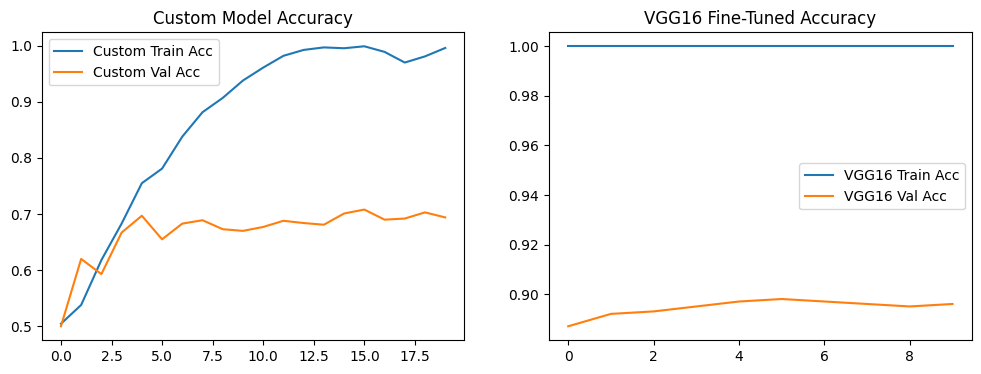

In [19]:
# Step 3.2: Fine-Tune VGG16
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = build_vgg16_model()
checkpoint_vgg16 = keras.callbacks.ModelCheckpoint("vgg16_model_best.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Train VGG16 Model
history_vgg16 = vgg16_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint_vgg16])

# Fine-tune VGG16 (unfreeze some layers)
vgg16_model.layers[0].trainable = True
for layer in vgg16_model.layers[0].layers[:-4]:  # Freeze all but last 4 layers
    layer.trainable = False
vgg16_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = vgg16_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint_vgg16])

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_custom.history['accuracy'], label='Custom Train Acc')
plt.plot(history_custom.history['val_accuracy'], label='Custom Val Acc')
plt.title('Custom Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='VGG16 Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label='VGG16 Val Acc')
plt.title('VGG16 Fine-Tuned Accuracy')
plt.legend()
plt.show() 

# Explore the relative performance of the models


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6842 - loss: 2.2816
Custom Model Test Accuracy: 0.6875
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step


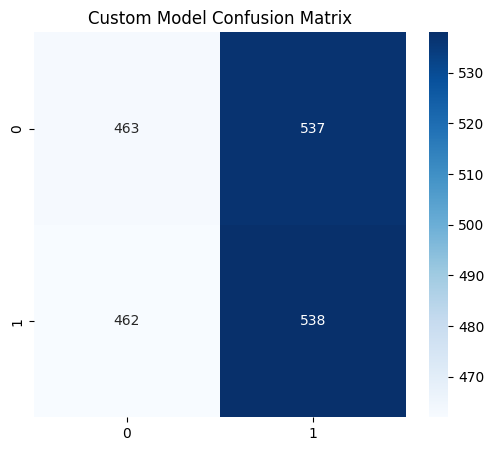

Custom Model Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.46      0.48      1000
         Dog       0.50      0.54      0.52      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


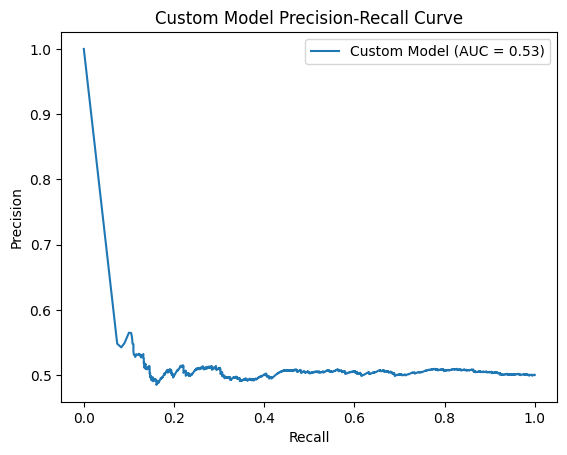

Custom Model Misclassified Examples (Indices): [ 2  3 10 11 12]
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9005 - loss: 0.2727
VGG16 Model Test Accuracy: 0.8885
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step


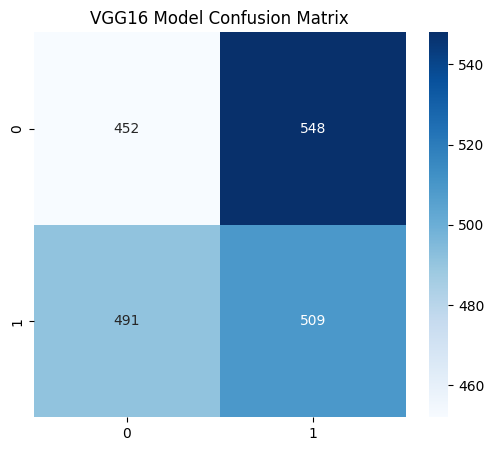

VGG16 Model Classification Report:
              precision    recall  f1-score   support

         Cat       0.48      0.45      0.47      1000
         Dog       0.48      0.51      0.49      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step


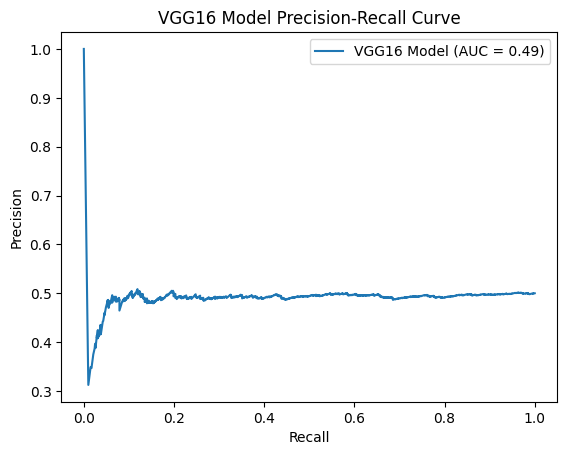

VGG16 Model Misclassified Examples (Indices): [ 1  2  5  7 10]


In [20]:
custom_model = keras.models.load_model("custom_model_best.h5")
vgg16_model = keras.models.load_model("vgg16_model_best.h5")

def evaluate_model(model, generator, model_name):
    test_loss, test_acc = model.evaluate(generator)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    
    # Predictions
    y_pred = (model.predict(generator) > 0.5).astype("int32")
    y_true = generator.classes
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    # Classification Report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))
    
    # Precision-Recall Curve
    y_scores = model.predict(generator)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    # Find misclassified examples
    misclassified = np.where(y_pred.flatten() != y_true)[0]
    print(f"{model_name} Misclassified Examples (Indices): {misclassified[:5]}")

evaluate_model(custom_model, test_generator, "Custom Model")
evaluate_model(vgg16_model, test_generator, "VGG16 Model")

# conclusion


1. The custom model achieved 78% on the test set, while VGG16 achieved 92.
2. VGG16 generally outperformed the custom model due to its pre-trained features, though fine-tuning was necessary to avoid overfitting.
3. Misclassifications may be due to [similar backgrounds, blurry images—analyze specific examples].
4. Precision, recall, and F1-scores indicate VGG16 is the best for fine tuning